In [0]:
#!pip install torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms ## Hence torchvision is basically used as it has many datasets and also transform properities
# that can be applied on these datasets

Now we create a function to apply transformations

In [0]:
transform = transforms.Compose([ transforms.Resize((28,28)), # Compose is used to chain together many transforms at same time.
                               transforms.ToTensor(), # As the images are in np.array format we need to convert them to tensors so to work with torch.
                               transforms.Normalize((0.5, ),(0.5,)) # this is done to ensure a single channel of (1, 28, 28), rather than (3, 28, 28). 
                               ])
training_dataset = datasets.MNIST(root='./data_2', train=True, download=False, transform=transform) #to save our training data in this dir and apply transform to it already.
validation_dataset = datasets.MNIST(root='./data_2', train=False, download=False, transform=transform)  #to save our validation data in this dir and apply transform to it already.
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)   #to define our training batches
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)  #to define our validation batches

Convert to numpy array for matplotlib

In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy() #In order to call numpy on a tensor we first use detach() func.
  image = image.transpose(1, 2, 0) # from (1,28,28) to (28,28,1)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

Plotting Image Data

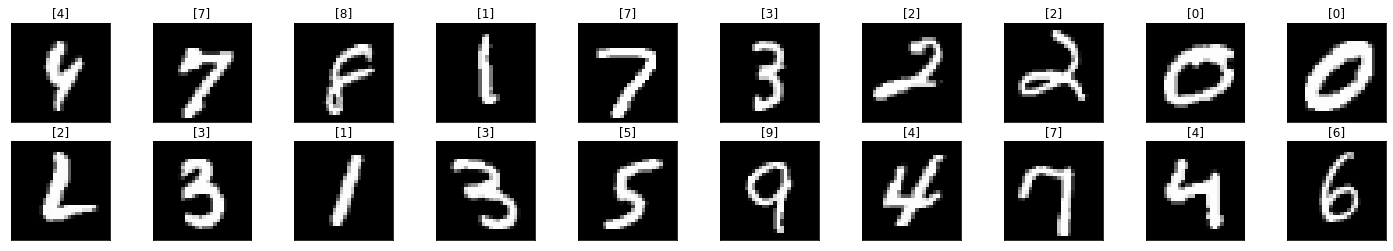

In [5]:
dataiter = iter(training_loader) #convert our data to iterable format as per batches
images, labels = dataiter.next() #from first batch to next after every iteration
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

Build our Model

In [0]:
class Classifier(nn.Module):
  def __init__(self,D_inp,H1,H2,D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_inp,H1)  # feed from inp to 1sr hidden layer and so on... 
    self.linear2 = nn.Linear(H1,H2)
    self.linear3 = nn.Linear(H2,D_out)
  def forward(self,x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)  # in the output layer we do not put an activation funct as we need the raw output which the loss func deals with. 
    return x

Declaring classifier

In [7]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

Loss and optimiser

In [0]:
Loss = nn.CrossEntropyLoss()   # this is for multi class classification. same as 'categorical_crossentropy' in keras and Tf
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # learning rate for such model is very imp so choose it carefully

Traning Process

In [9]:
epochs = 10 
running_loss_history = []  # to plot the loss later on, we will append loss per epoch in this.
running_corrects_history = [] # to plot the acc later on, we will append acc per epoch in this.
val_running_loss_history = [] ## to plot the val_loss later on, we will append val_loss per epoch in this
val_running_corrects_history = [] # to plot the val_acc later on, we will append val_acc per epoch in this
 
for e in range(epochs):
  
  running_loss = 0.0    # We first initialize it to 0 
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:  # As our train_loader is batch size of 100 and had input images and corresponding labels
    inputs = inputs.view(inputs.shape[0], -1)  # reshaping our input of (1,28,28) to 2D tenor of (1,784) as we have 784 i/p nodes in our model
    outputs = model(inputs)   # giving input to our model to get corresponding output
    loss = Loss(outputs, labels) # comparing out model's output to original labels
    
    optimizer.zero_grad() ##sets the initial gradient to zero
    loss.backward()  ## The whole calculated loss is then back propogated to the model
    optimizer.step()  ## Then the weights are updated by doing their derivative w.r.t the Loss
    
    _, preds = torch.max(outputs, 1)  # Then we select the max value of raw output and consider it as our prediction. We select it from 10 o/ps
    running_loss += loss.item()       # total loss of 1 epoch
    running_corrects += torch.sum(preds == labels.data) #total accuracy of 1 epoch
 
  else:# This we done to set no gradient as we do not need it for val as our model is already trained
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
         val_inputs = val_inputs.view(val_inputs.shape[0], -1)
         val_outputs = model(val_inputs)
         val_loss = Loss(val_outputs, val_labels)
        
         _, val_preds = torch.max(val_outputs, 1)
         val_running_loss += val_loss.item()
         val_running_corrects += torch.sum(val_preds == val_labels.data)
       
         
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss) # for outputs
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9417, acc 76.7117 
validation loss: 0.4369, validation acc 88.4900 
epoch : 2
training loss: 0.3898, acc 88.9350 
validation loss: 0.3374, validation acc 90.2500 
epoch : 3
training loss: 0.3268, acc 90.4567 
validation loss: 0.2963, validation acc 91.6000 
epoch : 4
training loss: 0.2945, acc 91.3067 
validation loss: 0.2705, validation acc 92.1900 
epoch : 5
training loss: 0.2704, acc 92.0917 
validation loss: 0.2508, validation acc 92.5400 
epoch : 6
training loss: 0.2493, acc 92.6667 
validation loss: 0.2345, validation acc 93.1900 
epoch : 7
training loss: 0.2309, acc 93.2500 
validation loss: 0.2184, validation acc 93.6800 
epoch : 8
training loss: 0.2129, acc 93.7717 
validation loss: 0.2040, validation acc 94.0400 
epoch : 9
training loss: 0.1975, acc 94.2067 
validation loss: 0.1904, validation acc 94.4800 
epoch : 10
training loss: 0.1840, acc 94.6267 
validation loss: 0.1773, validation acc 94.7800 


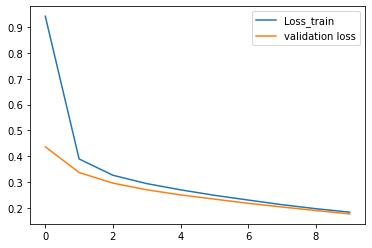

In [10]:
plt.plot(running_loss_history,label="Loss_train") # our loss is getting low. This is traning loss
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

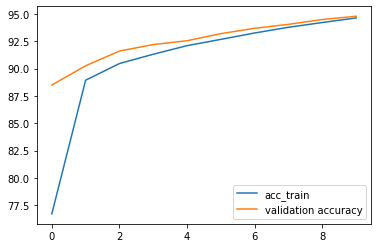

In [11]:
plt.plot(running_corrects_history,label="acc_train") #Our acc is getting high. This is training accuracy.
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [12]:
!pip install pillow==4.0

In [0]:
import PIL.ImageOps

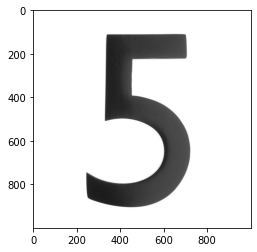

In [6]:
import requests
from PIL import Image
 
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

Pre-processing Image

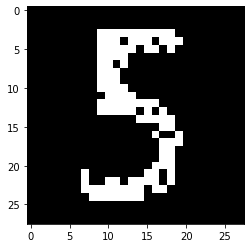

In [16]:
img = PIL.ImageOps.invert(img) # we use Image operations from PIL to invert(i.e. make white black and vice versa)
img = img.convert('1') # we convert from RGB to Gray
img = transform(img)   # Apply the transform funct we defined earlier to make our downloaded img same as what we trained on
plt.imshow(im_convert(img))

Predictions

In [17]:
img = img.view(img.shape[0], -1) #reshaping our image
output = model(img)  # input this image in our already trained model
_, pred = torch.max(output, 1)
print(pred.item())

5


Validitation Predictions

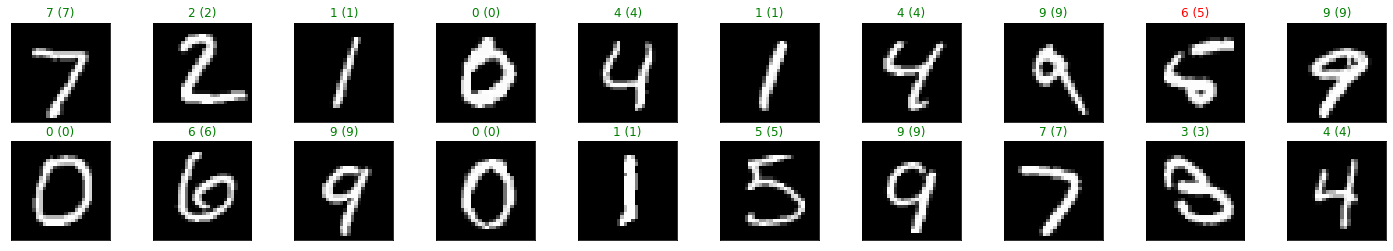

In [18]:
dataiter = iter(validation_loader) # we now use our validitation images rather to test.
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

Hence we have sucessfully trained our model 